<a href="https://colab.research.google.com/github/nickelodeon20/Test-Model-Performances/blob/main/ShallowFBCSPNet/ShallowFBCSPNet_BCI_IV2a_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Authors: Lukas Gemein <l.gemein@gmail.com>
#          Hubert Banville <hubert.jbanville@gmail.com>
#          Simon Brandt <simonbrandt@protonmail.com>
#          Daniel Wilson <dan.c.wil@gmail.com>
#
# License: BSD (3-clause)
!pip install braindecode # Install braindecode package
from braindecode.datasets import MOABBDataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 15.4 MB/s eta 0:00:00


In [4]:
subject_id = 3

!pip install moabb
!pip install --upgrade numpy==1.26.0
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached numpy-1.26.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

/usr/local/lib/python3.11/dist-packages/moabb/datasets/download.py:56: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 97.5GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|██████████████████████████████████████| 42.3M/42.3M 

In [5]:
!pip install --upgrade numpy

from numpy import multiply

from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

# Define a named function for volt-to-microvolt conversion
def convert_to_microvolts(data, factor=factor):
    return multiply(data, factor)

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(convert_to_microvolts,  apply_on_array=True),  # Convert from V to uV using the named function
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 113.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skorch 1.1.0 requires scikit-learn>=0.22.0, which is not installed.
moabb 1.2.0 requires scikit-learn<1.6, which is not installed.
pyriemann 0.7 requires scikit-learn>=0.24, which is not installed.
librosa 0.11.0 requires scikit-learn>=1.1.0, which is not installed.
fastai 2.7.19 requires scikit-learn, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
moabb 1.2.0 requires numpy<2.0,>=1.22, but you have numpy 2.2.4 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.4 which is incompatible.


In [6]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np.str_('tongue')]
Used Annotations descriptions: [np.str_('feet'), np.str_('left_hand'), np.str_('right_hand'), np

In [7]:
from braindecode.datasets import BaseConcatDataset

# Debugging function to check shapes of datasets
def get_baseconcatdataset_shape(dataset):
    """
    Gets the shape of a BaseConcatDataset.

    Args:
        dataset: The BaseConcatDataset object.

    Returns:
        A tuple representing the shape of the dataset: (num_examples, num_channels, num_timepoints).
    """

    num_examples = len(dataset)

    # If dataset is empty, return (num_examples, 0, 0)
    if not dataset.datasets:
        return (num_examples, 0, 0)

    # Assume all datasets have the same shape, access shape of the first example
    # of the first dataset
    num_channels = dataset.datasets[0][0][0].shape[0]
    num_timepoints = dataset.datasets[0][0][0].shape[1]

    return (num_examples, num_channels, num_timepoints)



# Split the dataset into training and validation set.

splitted = windows_dataset.split('session')
train_set = splitted['0train']  # Session train
valid_set = splitted['1test']  # Session evaluation
print("Windows_dataset before split: " + str(get_baseconcatdataset_shape(windows_dataset)))
print("------------------------------")
print("Valid_set before split: " + str(get_baseconcatdataset_shape(valid_set)))
print("------------------------------")
print("Train_set (not involved in split): " + str(get_baseconcatdataset_shape(train_set)) + "\n")

# Get the list of datasets within valid_set
valid_set_datasets = valid_set.datasets

# Create new split indices within the valid_set
n_valid_trials = len(valid_set_datasets)
valid_subset1_ids = list(range(0, int(0.8 * n_valid_trials)))  # First half of valid_set
valid_subset2_ids = list(range(int(0.8 * n_valid_trials), n_valid_trials))  # Second half of valid_set

print("Valid Set ids: " + str(valid_subset1_ids))
print("------------------------------")
print("Test Set ids: " + str(valid_subset2_ids) + "\n")

# Create subsets of valid_set based on indices
valid_set_subset = BaseConcatDataset([valid_set_datasets[i] for i in valid_subset1_ids])
test_set = BaseConcatDataset([valid_set_datasets[i] for i in valid_subset2_ids])



# Update the valid_set with the new subsets
valid_set.datasets = valid_set_subset

print("Valid_set after split: " + str(get_baseconcatdataset_shape(valid_set_subset)))
print("------------------------------")
print("Test_set after split (N/A before): " + str(get_baseconcatdataset_shape(test_set)))
print("------------------------------")
print("Train_set (not involved in split): " + str(get_baseconcatdataset_shape(train_set)))



Windows_dataset before split: (576, 22, 1125)
------------------------------
Valid_set before split: (288, 22, 1125)
------------------------------
Train_set (not involved in split): (288, 22, 1125)

Valid Set ids: [0, 1, 2, 3]
------------------------------
Test Set ids: [4, 5]

Valid_set after split: (192, 22, 1125)
------------------------------
Test_set after split (N/A before): (96, 22, 1125)
------------------------------
Train_set (not involved in split): (288, 22, 1125)


In [8]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model = model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 1101, 1]          [1, 40, 1101, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 1101, 1]          [1, 40, 69, 1]            --                        [75, 1]
├─Express

/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [9]:
from skorch.callbacks import LRScheduler, EpochScoring
from skorch.helper import predefined_split

from braindecode import EEGClassifier

# We found these values to be good for the shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 50


clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set_subset),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ('train_acc', EpochScoring(scoring='accuracy', on_train=True, name='train_acc')),
               ('train_f1', EpochScoring(scoring='f1_macro', on_train=True, name='train_f1')),
                ('precision', EpochScoring(scoring='precision_macro', on_train=True, name='train_precision')),
                ('recall', EpochScoring(scoring='recall_macro', on_train=True, name='train_recall'))  # Add the F1 score callback

    ],
    device=device,
    classes=classes,
)
# Model training for the specified number of epochs. `y` is None as it is
# already supplied in the dataset.
_ = clf.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_acc    train_f1    train_loss    train_precision    train_recall    valid_acc    valid_loss      lr     dur
-------  -----------  ----------  ------------  -----------------  --------------  -----------  ------------  ------  ------
      1       0.2539      0.2513        1.6001             0.2581          0.2528       0.2500        6.5880  0.0006  0.3150
      2       0.4648      0.4670        1.2446             0.4778          0.4644       0.2500        7.2081  0.0006  0.2818
      3       0.5273      0.5296        1.1024             0.5309          0.5296       0.2865        6.4782  0.0006  0.2906
      4       0.5664      0.5642        0.9415             0.5671          0.5651       0.2708        5.5066  0.0006  0.3053
      5       0.5977      0.5995        0.9476             0.6039          0.5986       0.2500        4.9508  0.0006  0.2810
      6       0.7031      0.6980        0.7592             0.7045          0.7038       0.2604        3.8463  0.0006  0.2924


Line Graph

<ipython-input-25-ae33a406a97f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', 10)  # Get 'viridis' with 10 colors


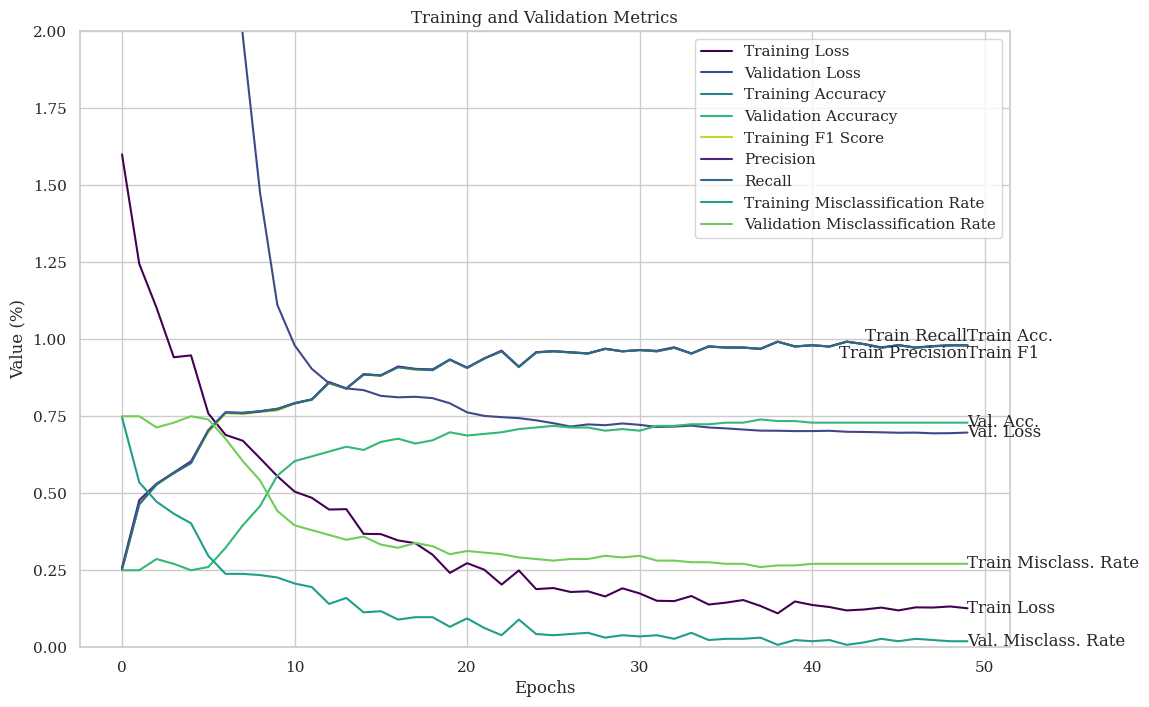

In [25]:
import matplotlib.pyplot as plt
from numpy import array, arange
from matplotlib import cm

# Extract the values for the metrics
train_loss = clf.history_[:, 'train_loss']
valid_loss = clf.history_[:, 'valid_loss']
train_acc = clf.history_[:, 'train_acc']
valid_acc = clf.history_[:, 'valid_acc']
train_f1 = clf.history_[:, 'train_f1']
precision = clf.history_[:, 'train_precision']
recall = clf.history_[:, 'train_recall']

# Calculate misclassification rates
train_misclass = (100 - 100 * array(train_acc))/100
valid_misclass = (100 - 100 * array(valid_acc))/100

# Get a colormap
cmap = cm.get_cmap('viridis', 10)

# Create the plot
epochs = arange(len(train_loss))

plt.figure(figsize=(12, 8))

plt.plot(epochs, train_loss, label='Training Loss', color=cmap(0))
plt.plot(epochs, valid_loss, label='Validation Loss', color=cmap(2))
plt.plot(epochs, train_acc, label='Training Accuracy', color=cmap(4))
plt.plot(epochs, valid_acc, label='Validation Accuracy', color=cmap(6))
plt.plot(epochs, train_f1, label='Training F1 Score', color=cmap(8))
plt.plot(epochs, precision, label='Precision', color=cmap(1))
plt.plot(epochs, recall, label='Recall', color=cmap(3))
plt.plot(epochs, train_misclass, label='Training Misclassification Rate', color=cmap(5))
plt.plot(epochs, valid_misclass, label='Validation Misclassification Rate', color=cmap(7))

plt.text(epochs[-1], train_loss[-1], 'Train Loss', ha='left', va='center')
plt.text(epochs[-1], valid_loss[-1], 'Val. Loss', ha='left', va='center')
plt.text(epochs[-1], train_acc[-1], 'Train Acc.', ha='left', va='bottom')
plt.text(epochs[-1], valid_acc[-1], 'Val. Acc.', ha='left', va='center')
plt.text(epochs[-1], train_f1[-1], 'Train F1', ha='left', va='top')
plt.text(epochs[-1], precision[-1], 'Train Precision', ha='right', va='top')
plt.text(epochs[-1], recall[-1], 'Train Recall', ha='right', va='bottom')
plt.text(epochs[-1], train_misclass[-1], 'Val. Misclass. Rate', ha='left', va='center')
plt.text(epochs[-1], valid_misclass[-1], 'Train Misclass. Rate', ha='left', va='center')


plt.ylim(0, 2)

plt.xlabel('Epochs')
plt.ylabel('Value (%)')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True, )
plt.show()


Validation Confusion Matrices


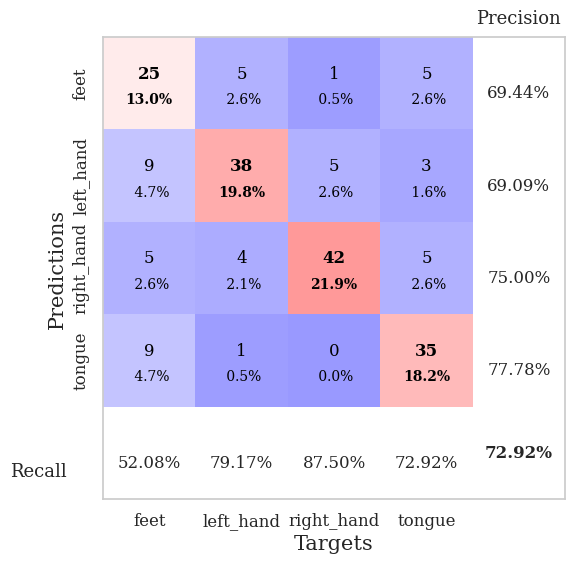

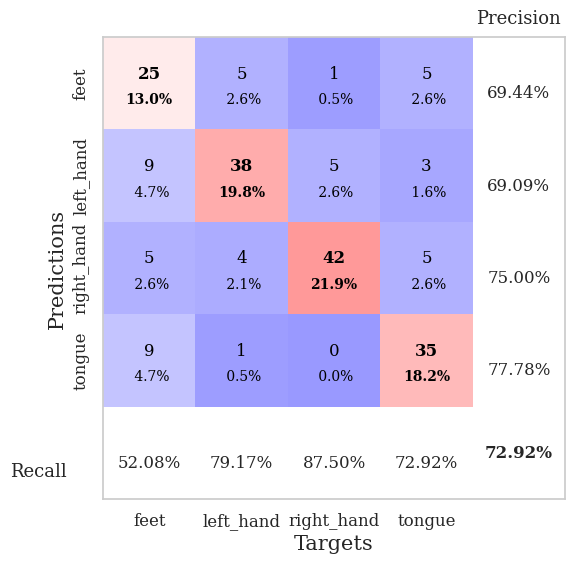

In [26]:
from sklearn.metrics import confusion_matrix

from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set_subset.get_metadata().target
y_pred = clf.predict(valid_set_subset)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)


# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels, figsize=(6, 6))



Test Confusion Matrices

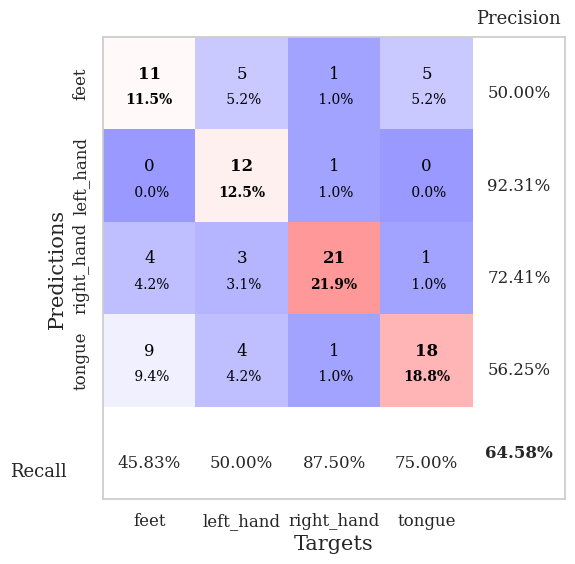

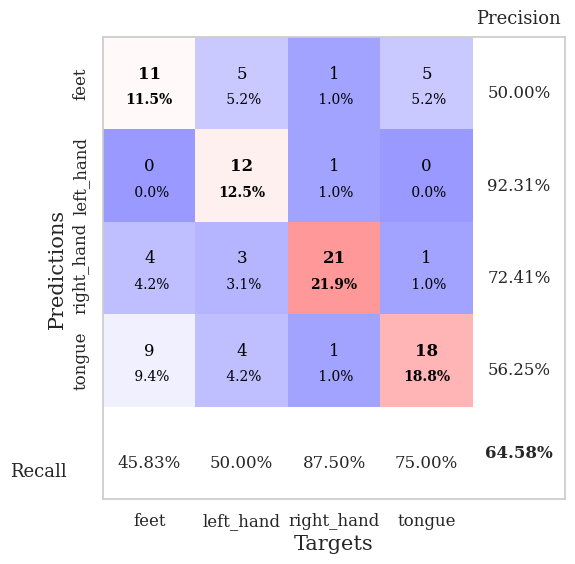

In [27]:
# generate confusion matrices
# get the targets
y_true_test = test_set.get_metadata().target
y_pred_test = clf.predict(test_set)

# generating confusion matrix
confusion_mat_test = confusion_matrix(y_true_test, y_pred_test)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = windows_dataset.datasets[0].window_kwargs[0][1]['mapping']
# sort the labels by values (values are integer class labels)
labels = [k for k, v in sorted(label_dict.items(), key=lambda kv: kv[1])]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat_test, class_names=labels, figsize=(6, 6))